<h1 style="background-color: Teal; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Merging the datasets
</h1>

In [11]:
%pip install scikit-fuzzy

Note: you may need to restart the kernel to use updated packages.


In [46]:
#important libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples # new library
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import skfuzzy as fuzz
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors


%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

In [47]:
# Helper function from previous labs
def get_ss(df, features):
    """Calculate total sum of squares (SST)"""
    return np.sum(df[features].var() * (df[features].count() - 1))

def get_ssw(df, features, labels):
    """Calculate within-cluster sum of squares (SSW)"""
    df_temp = df[features].copy()
    df_temp['labels'] = labels
    return df_temp.groupby('labels')[features].apply(lambda x: get_ss(x, features)).sum()

def get_rsq(df, features, labels):
    """Calculate R² for clustering quality"""
    sst = get_ss(df, features)
    ssw = get_ssw(df, features, labels)
    return 1 - (ssw / sst)

In [13]:
# Load the datasets after EDA
df_flights_eda = pd.read_csv('DM_AIAI_FlightsDB_after_eda.csv') 
df_costumers_eda = pd.read_csv('DM_AIAI_CustomersDB_after_eda.csv')

In [14]:
df_flights_eda.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,Recency_Months,PointsRedeemRatio,FlightsWithCompanionsRatio
0,100018,225,45,53014.30,20562.8,0.0,0.387873,0.200000
1,100102,245,55,33903.96,18760.6,0.0,0.553345,0.224490
2,100140,211,51,43192.58,4896.0,1.0,0.113353,0.241706
3,100214,108,17,36453.77,12908.6,0.0,0.354109,0.157407
4,100272,181,50,42953.25,10891.4,1.0,0.253564,0.276243


In [15]:
df_costumers_eda.head()

,Loyalty#,Province or State,City,Latitude,Longitude,Postal code,Education,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Income_Class,CustomerTenure,Active_Client
0,480934,Ontario,Toronto,43.653225,-79.383186,M2Z 4K1,Bachelor,70146.0,Married,Star,2019-02-15,2021-12-31,3839.14,Standard,Non-Zero Income,1050,Active
1,549612,Alberta,Edmonton,53.544388,-113.490930,T3G 6Y6,College,0.0,Divorced,Star,2019-03-09,2021-12-31,3839.61,Standard,Zero Income,1028,Active
2,429460,British Columbia,Vancouver,49.282730,-123.120740,V6E 3D9,College,0.0,Single,Star,2017-07-14,2021-01-08,3839.75,Standard,Zero Income,1274,Inactive
3,608370,Ontario,Toronto,43.653225,-79.383186,P1W 1K4,College,0.0,Single,Star,2016-02-17,2021-12-31,3839.75,Standard,Zero Income,2144,Active
4,530508,Quebec,Hull,45.428730,-75.713364,J8Y 3Z5,Bachelor,97832.0,Married,Star,2017-10-25,2021-12-31,3842.79,2021 Promotion,Non-Zero Income,1528,Active


In [16]:
merged_df = df_flights_eda.merge(df_costumers_eda, on="Loyalty#", how = "inner" ) #merging both datasets

In [17]:
merged_df.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,Recency_Months,PointsRedeemRatio,FlightsWithCompanionsRatio,Province or State,City,...,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Income_Class,CustomerTenure,Active_Client
0,100018,225,45,53014.30,20562.8,0.0,0.387873,0.200000,Alberta,Edmonton,...,82877.0,Married,Aurora,2019-08-09,2021-12-31,7919.20,Standard,Non-Zero Income,875,Active
1,100102,245,55,33903.96,18760.6,0.0,0.553345,0.224490,Ontario,Toronto,...,0.0,Single,Nova,2016-03-09,2021-12-31,2887.74,Standard,Zero Income,2123,Active
2,100140,211,51,43192.58,4896.0,1.0,0.113353,0.241706,British Columbia,Dawson Creek,...,0.0,Divorced,Nova,2019-07-30,2021-12-31,2838.07,Standard,Zero Income,885,Active
3,100214,108,17,36453.77,12908.6,0.0,0.354109,0.157407,British Columbia,Vancouver,...,42837.0,Married,Star,2018-08-06,2021-12-31,4170.57,Standard,Non-Zero Income,1243,Active
4,100272,181,50,42953.25,10891.4,1.0,0.253564,0.276243,Ontario,Toronto,...,80979.0,Divorced,Star,2017-01-09,2021-12-31,6622.05,Standard,Non-Zero Income,1817,Active


In [18]:
merged_df.head()

,Loyalty#,NumFlights,NumFlightsWithCompanions,PointsAccumulated,PointsRedeemed,Recency_Months,PointsRedeemRatio,FlightsWithCompanionsRatio,Province or State,City,...,Income,Marital Status,LoyaltyStatus,EnrollmentDateOpening,CancellationDate,Customer Lifetime Value,EnrollmentType,Income_Class,CustomerTenure,Active_Client
0,100018,225,45,53014.30,20562.8,0.0,0.387873,0.200000,Alberta,Edmonton,...,82877.0,Married,Aurora,2019-08-09,2021-12-31,7919.20,Standard,Non-Zero Income,875,Active
1,100102,245,55,33903.96,18760.6,0.0,0.553345,0.224490,Ontario,Toronto,...,0.0,Single,Nova,2016-03-09,2021-12-31,2887.74,Standard,Zero Income,2123,Active
2,100140,211,51,43192.58,4896.0,1.0,0.113353,0.241706,British Columbia,Dawson Creek,...,0.0,Divorced,Nova,2019-07-30,2021-12-31,2838.07,Standard,Zero Income,885,Active
3,100214,108,17,36453.77,12908.6,0.0,0.354109,0.157407,British Columbia,Vancouver,...,42837.0,Married,Star,2018-08-06,2021-12-31,4170.57,Standard,Non-Zero Income,1243,Active
4,100272,181,50,42953.25,10891.4,1.0,0.253564,0.276243,Ontario,Toronto,...,80979.0,Divorced,Star,2017-01-09,2021-12-31,6622.05,Standard,Non-Zero Income,1817,Active


In [19]:
merged_df["EnrollmentDateOpening"] = pd.to_datetime(merged_df["EnrollmentDateOpening"])
merged_df["CancellationDate"] = pd.to_datetime(merged_df["CancellationDate"])
merged_df["Enroll_Year"] = merged_df["EnrollmentDateOpening"].dt.year
merged_df["Enroll_Month"] = merged_df["EnrollmentDateOpening"].dt.month

In [20]:
merged_df.set_index("Loyalty#", inplace=True)

In [21]:
merged_df.dtypes

NumFlights                             int64
NumFlightsWithCompanions               int64
PointsAccumulated                    float64
PointsRedeemed                       float64
Recency_Months                       float64
PointsRedeemRatio                    float64
FlightsWithCompanionsRatio           float64
Province or State                     object
City                                  object
Latitude                             float64
Longitude                            float64
Postal code                           object
Education                             object
Income                               float64
Marital Status                        object
LoyaltyStatus                         object
EnrollmentDateOpening         datetime64[ns]
CancellationDate              datetime64[ns]
Customer Lifetime Value              float64
EnrollmentType                        object
Income_Class                          object
CustomerTenure                         int64
Active_Cli

In [22]:
#Splitting diferent features into categorical and numerical
numerical = ['NumFlights', 'NumFlightsWithCompanions', 'PointsAccumulated','PointsRedeemed',
             'PointsRedeemRatio', 'FlightsWithCompanionsRatio','Latitude', 'Longitude', 'Income', 'Customer Lifetime Value',
             'Enroll_Year', 'Enroll_Month']

categorical = ['Province or State', 'City', 'Postal code', 'Education', 'Marital Status', 'LoyaltyStatus', 'EnrollmentType', 'EnrollmentDateOpening', 'CancellationDate']

In [23]:
#X_cat = OneHotEncoder(sparse_output=False).fit_transform(merged_df[categorical])
X_num = StandardScaler().fit_transform(merged_df[numerical])

Now that we finished merging our datasets, we are ready to start testing the diferent types of clustering methods, in this project we will test, Agglomerative, K-means and Fuzzy Clustering.

<h1 style="background-color: Teal; color:white; padding:3px 6px; border-radius:4px; font-weight:bold;">
Clustering
</h1>

### Agglomerative Clustering

In [24]:
#X = np.hstack([X_num, X_cat])
X = X_num.copy()  # Using only numerical features for clustering
Z = linkage(X, method="ward")

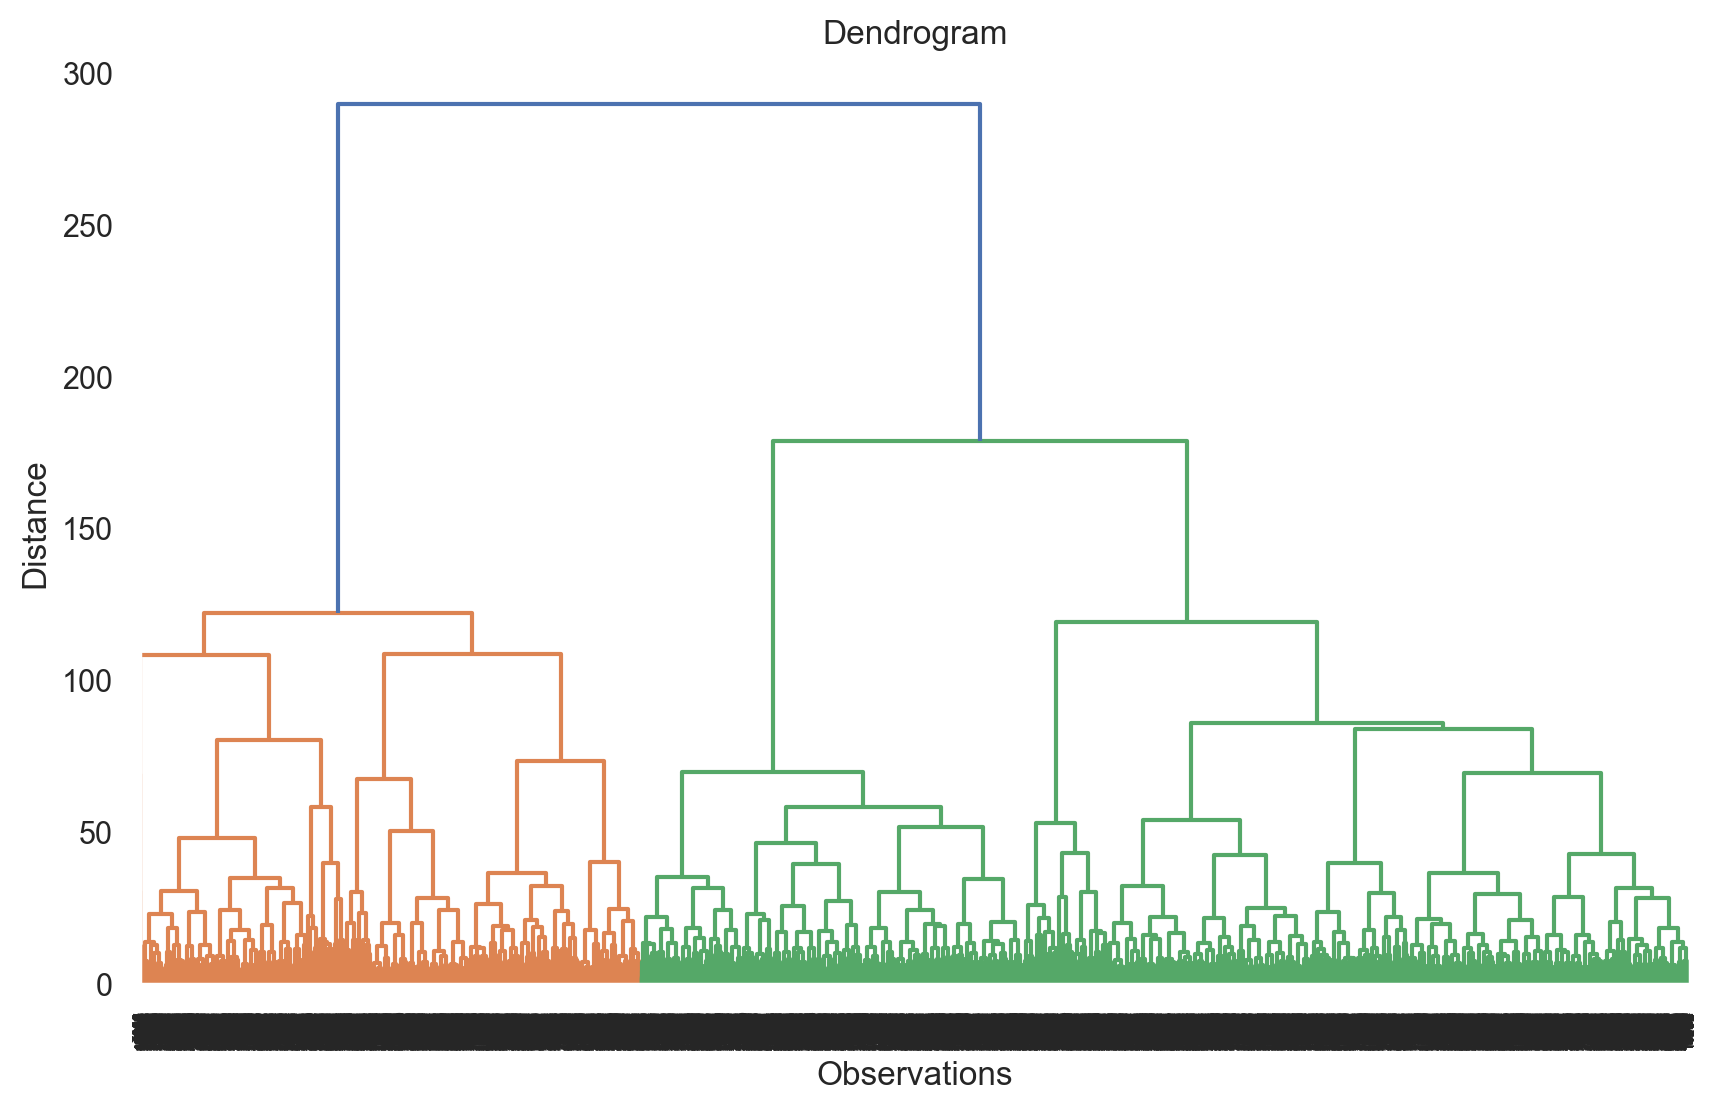

In [25]:
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()

Determination of the Optimal Number of Clusters Using a Dendrogram:

The hierarchical clustering structure was analyzed using a dendrogram in order to determine the optimal number of clusters. The dendrogram represents the successive merging of observations based on their linkage distances.

A clear and substantial increase in linkage distance is observed at the final merge (from two clusters to one), which suggests that combining these two groups would result in the aggregation of highly dissimilar clusters. According to standard hierarchical clustering criteria, this indicates that **two clusters** provide the strongest overall separation and represent the most robust solution.

However, an earlier but still significant increase in linkage distance can be identified at an intermediate level, approximately between distances of 130 and 200. Cutting the dendrogram at this level yields **three clusters**, which remain well separated and internally coherent.

In summary:
- **Two clusters** offer the simplest and most robust partition, maximizing separation between groups.
- **Three clusters** provide a more granular and informative segmentation while maintaining meaningful inter-cluster distances.

Therefore, while two clusters represent the primary choice based on the largest distance jump, **three clusters also constitute a valid and justifiable alternative**, particularly when a more detailed cluster interpretation is desired. Let's test with 2 and 3 clusters and compare the results.


In [26]:
#3 cluster solution
hc3 = AgglomerativeClustering(
    n_clusters=3,
    linkage='ward',
    metric='euclidean'
)

labels_hc3 = hc3.fit_predict(X)

In [27]:
#2 cluster solution
hc2_clust = AgglomerativeClustering(n_clusters=2, linkage='ward', metric='euclidean')
hc2_labels = hc2_clust.fit_predict(X)

In [28]:

pd.crosstab(
    pd.Series(labels_hc3, name='hc3_labels', index=merged_df.index),
    pd.Series(hc2_labels, name='hc2_labels', index=merged_df.index),
    )

hc2_labels,0,1
hc3_labels,,
0,0,5371
1,7119,0
2,4084,0


### KMeans


In [29]:
X2 = X_num.copy()
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X2)
    inertia.append(kmeans.inertia_)


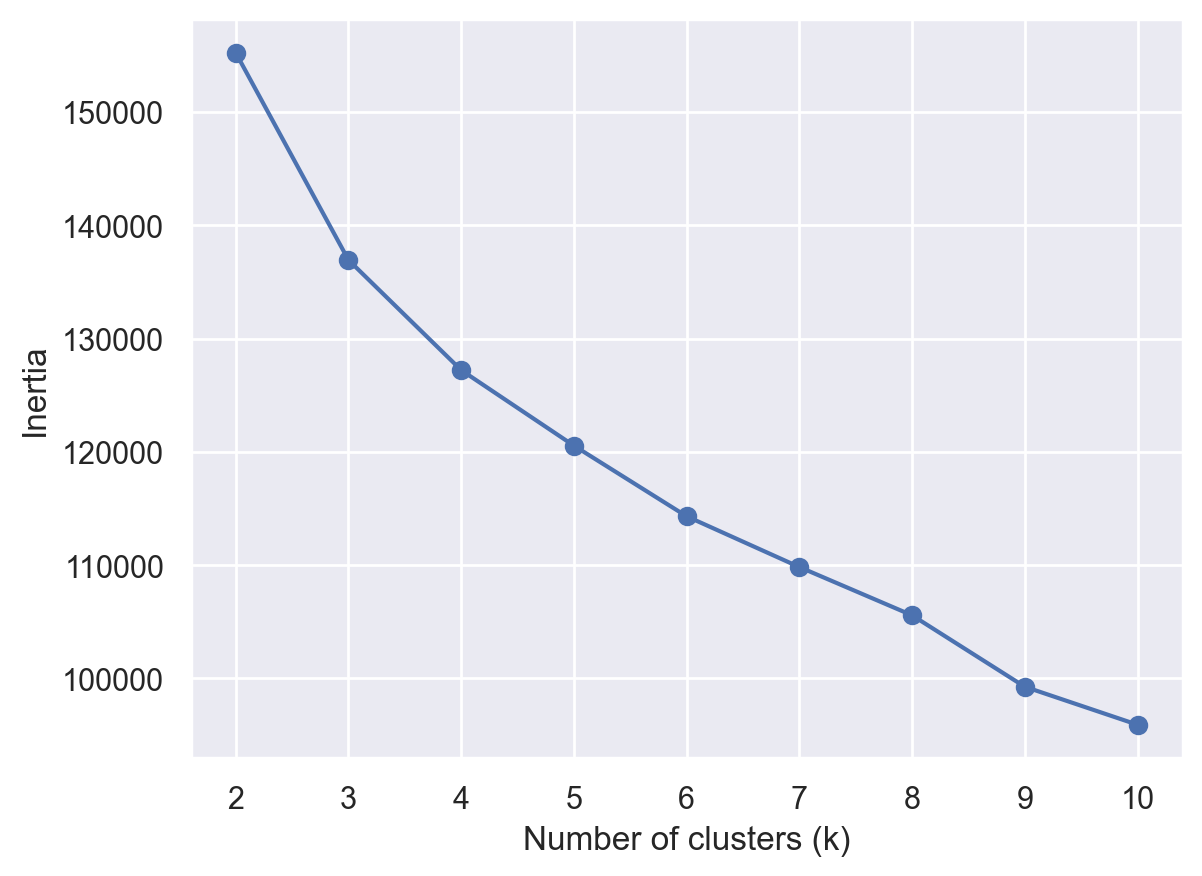

In [30]:
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

In [43]:
range_clusters = range(1, 7)

In [44]:
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(X2)  # fit the model to the data
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

For n_clusters = 2, the average silhouette_score is : 0.2375335247265969
For n_clusters = 3, the average silhouette_score is : 0.18882645300464487
For n_clusters = 4, the average silhouette_score is : 0.1818997914422191
For n_clusters = 5, the average silhouette_score is : 0.15167751325033746
For n_clusters = 6, the average silhouette_score is : 0.15548989680880612


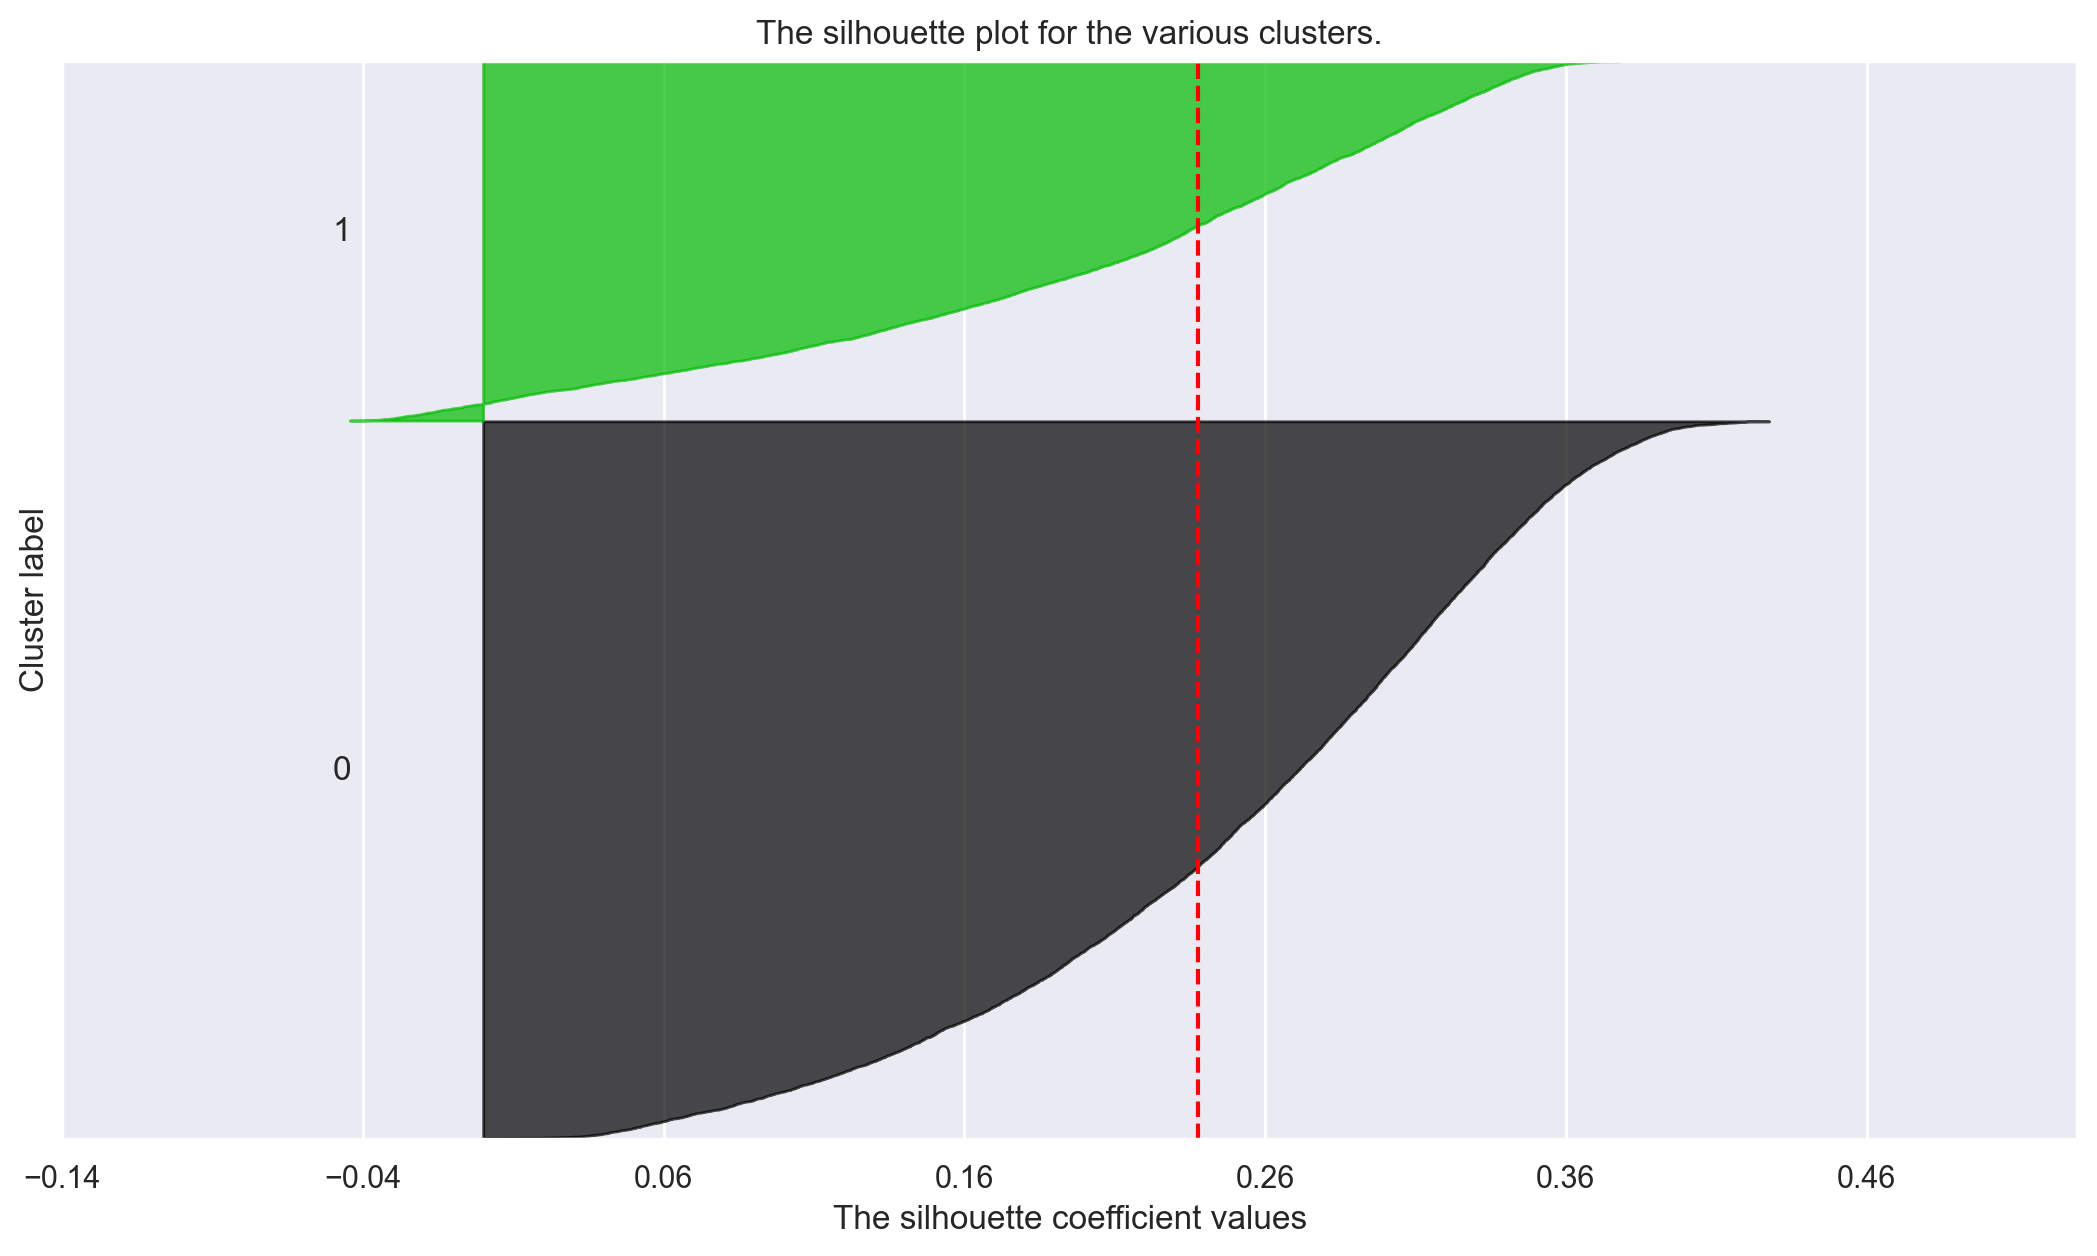

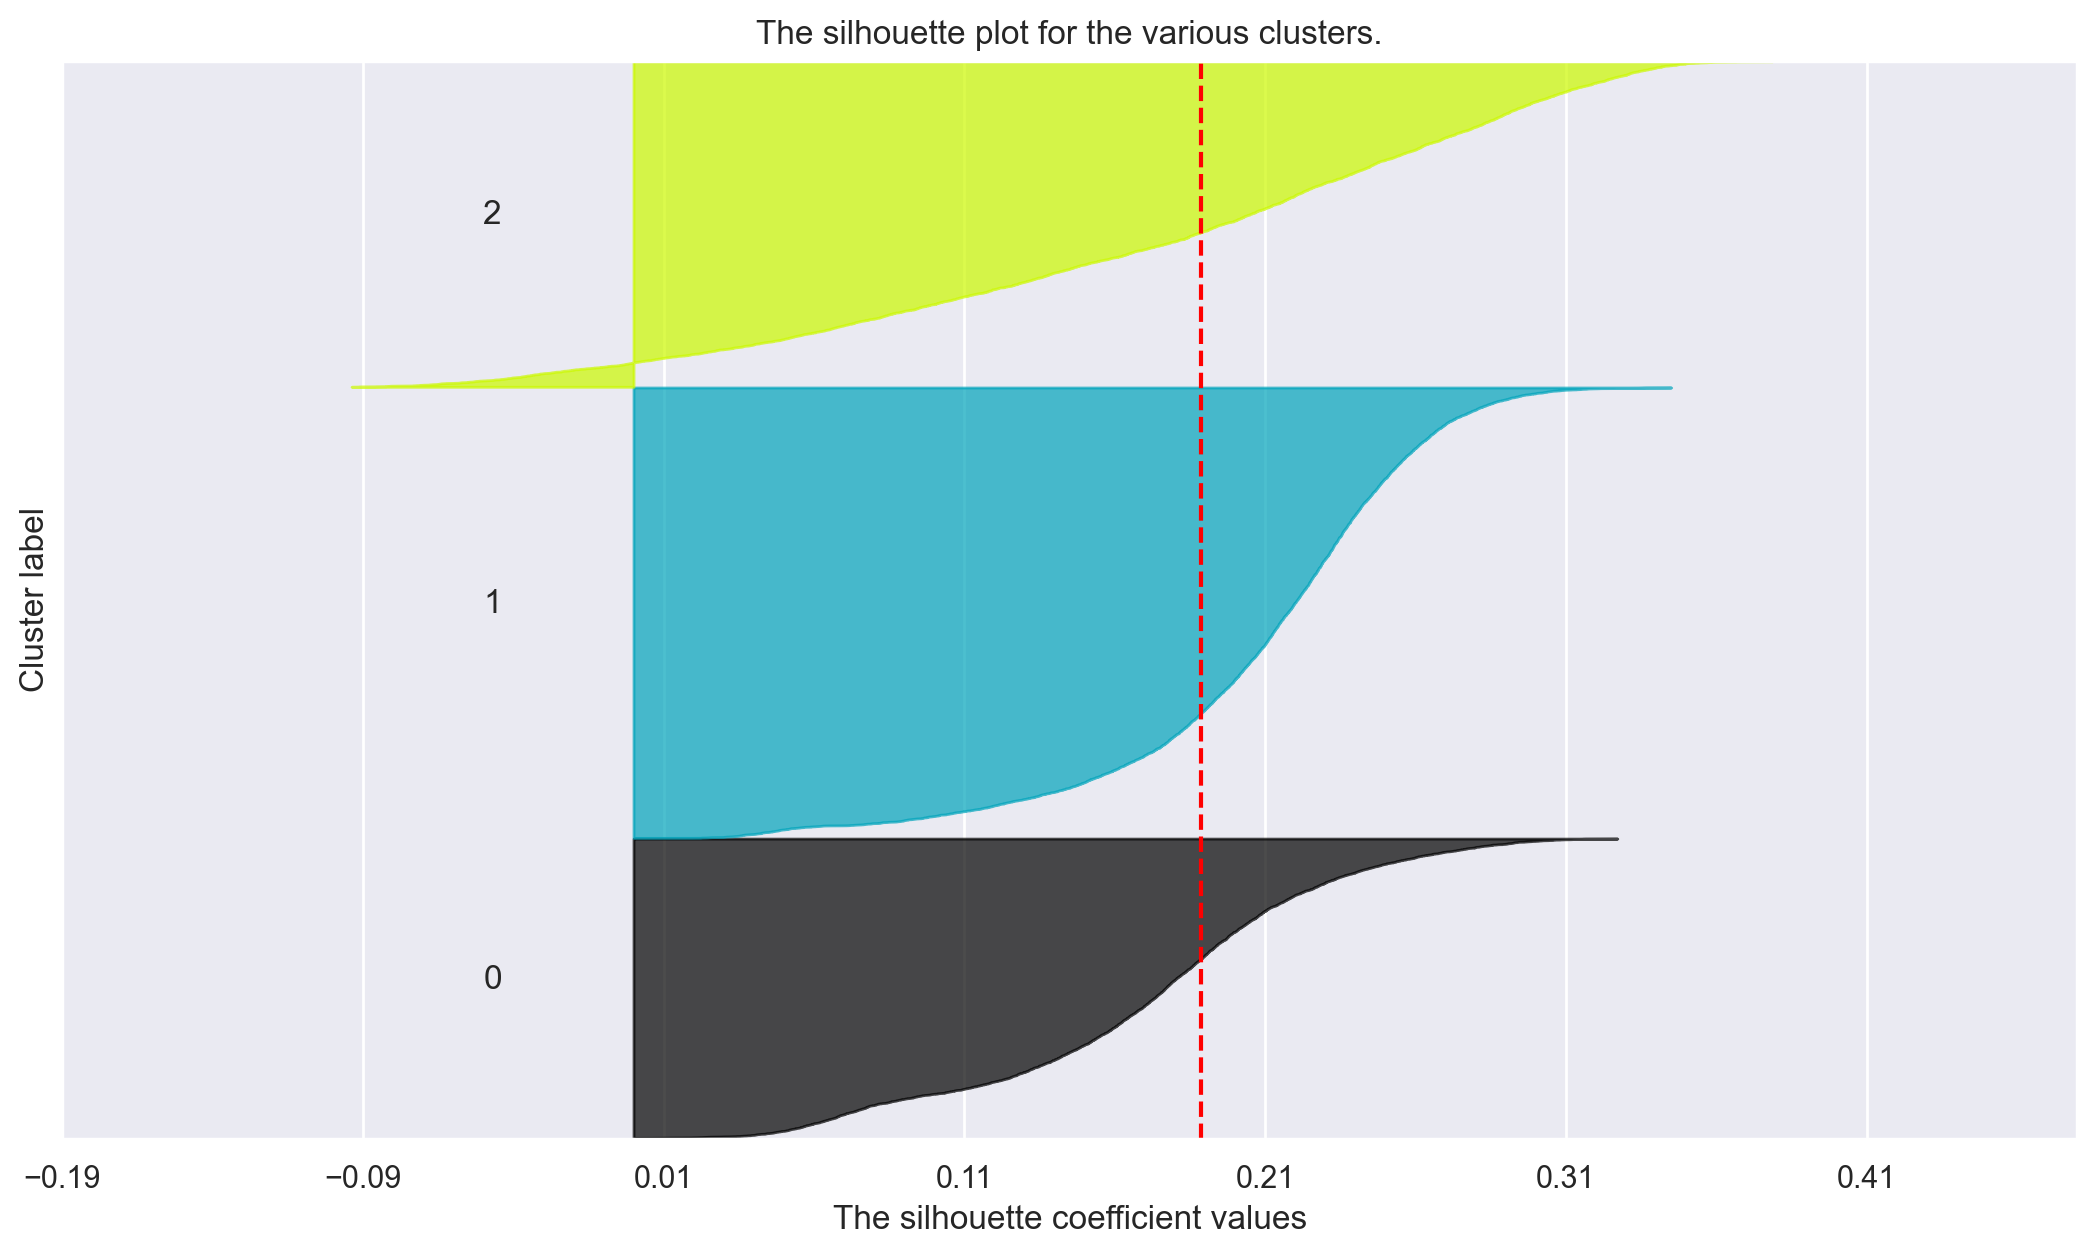

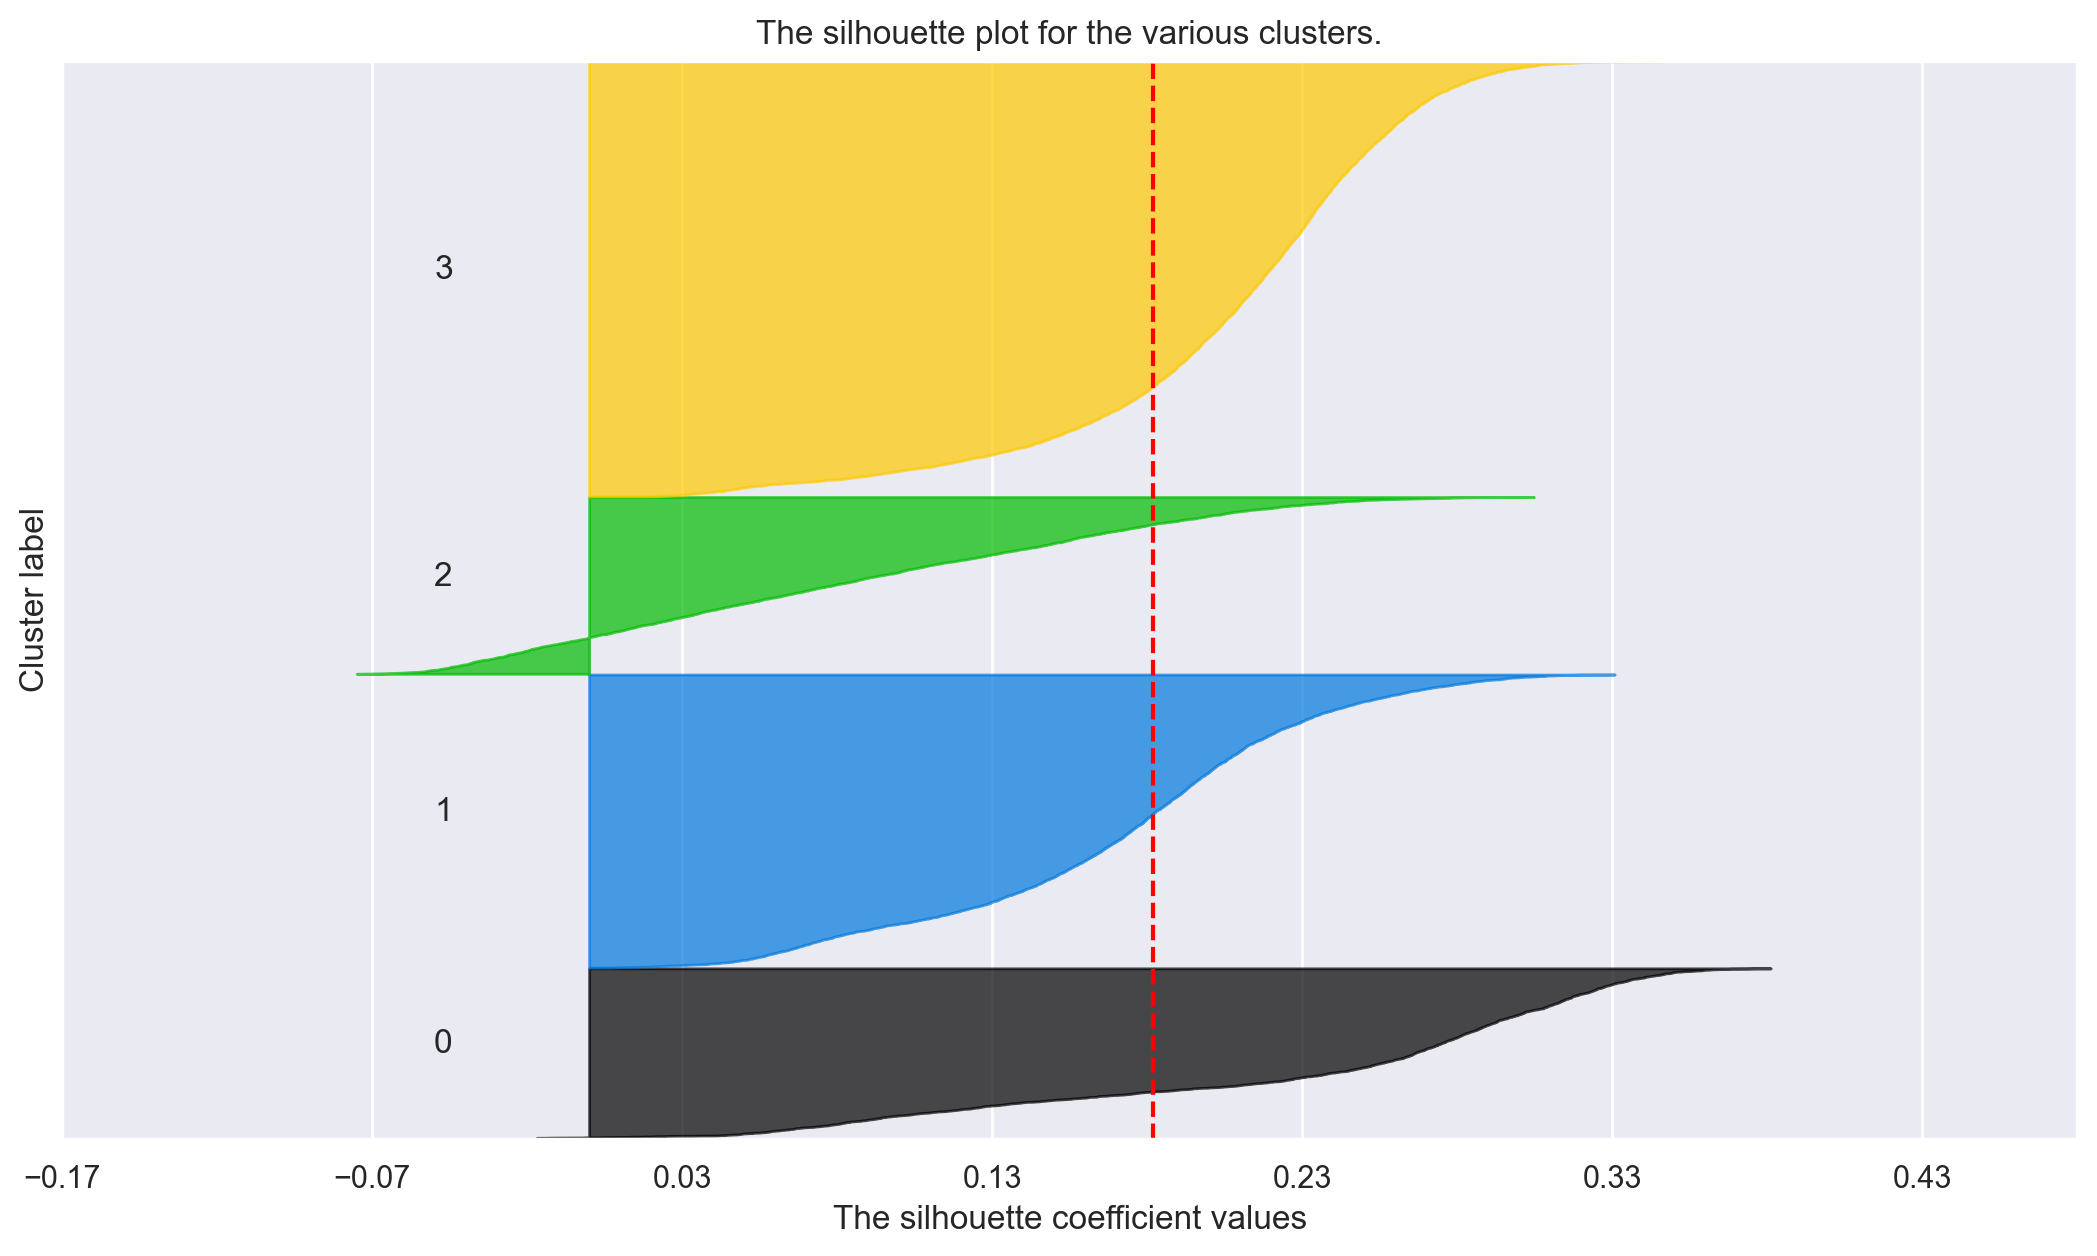

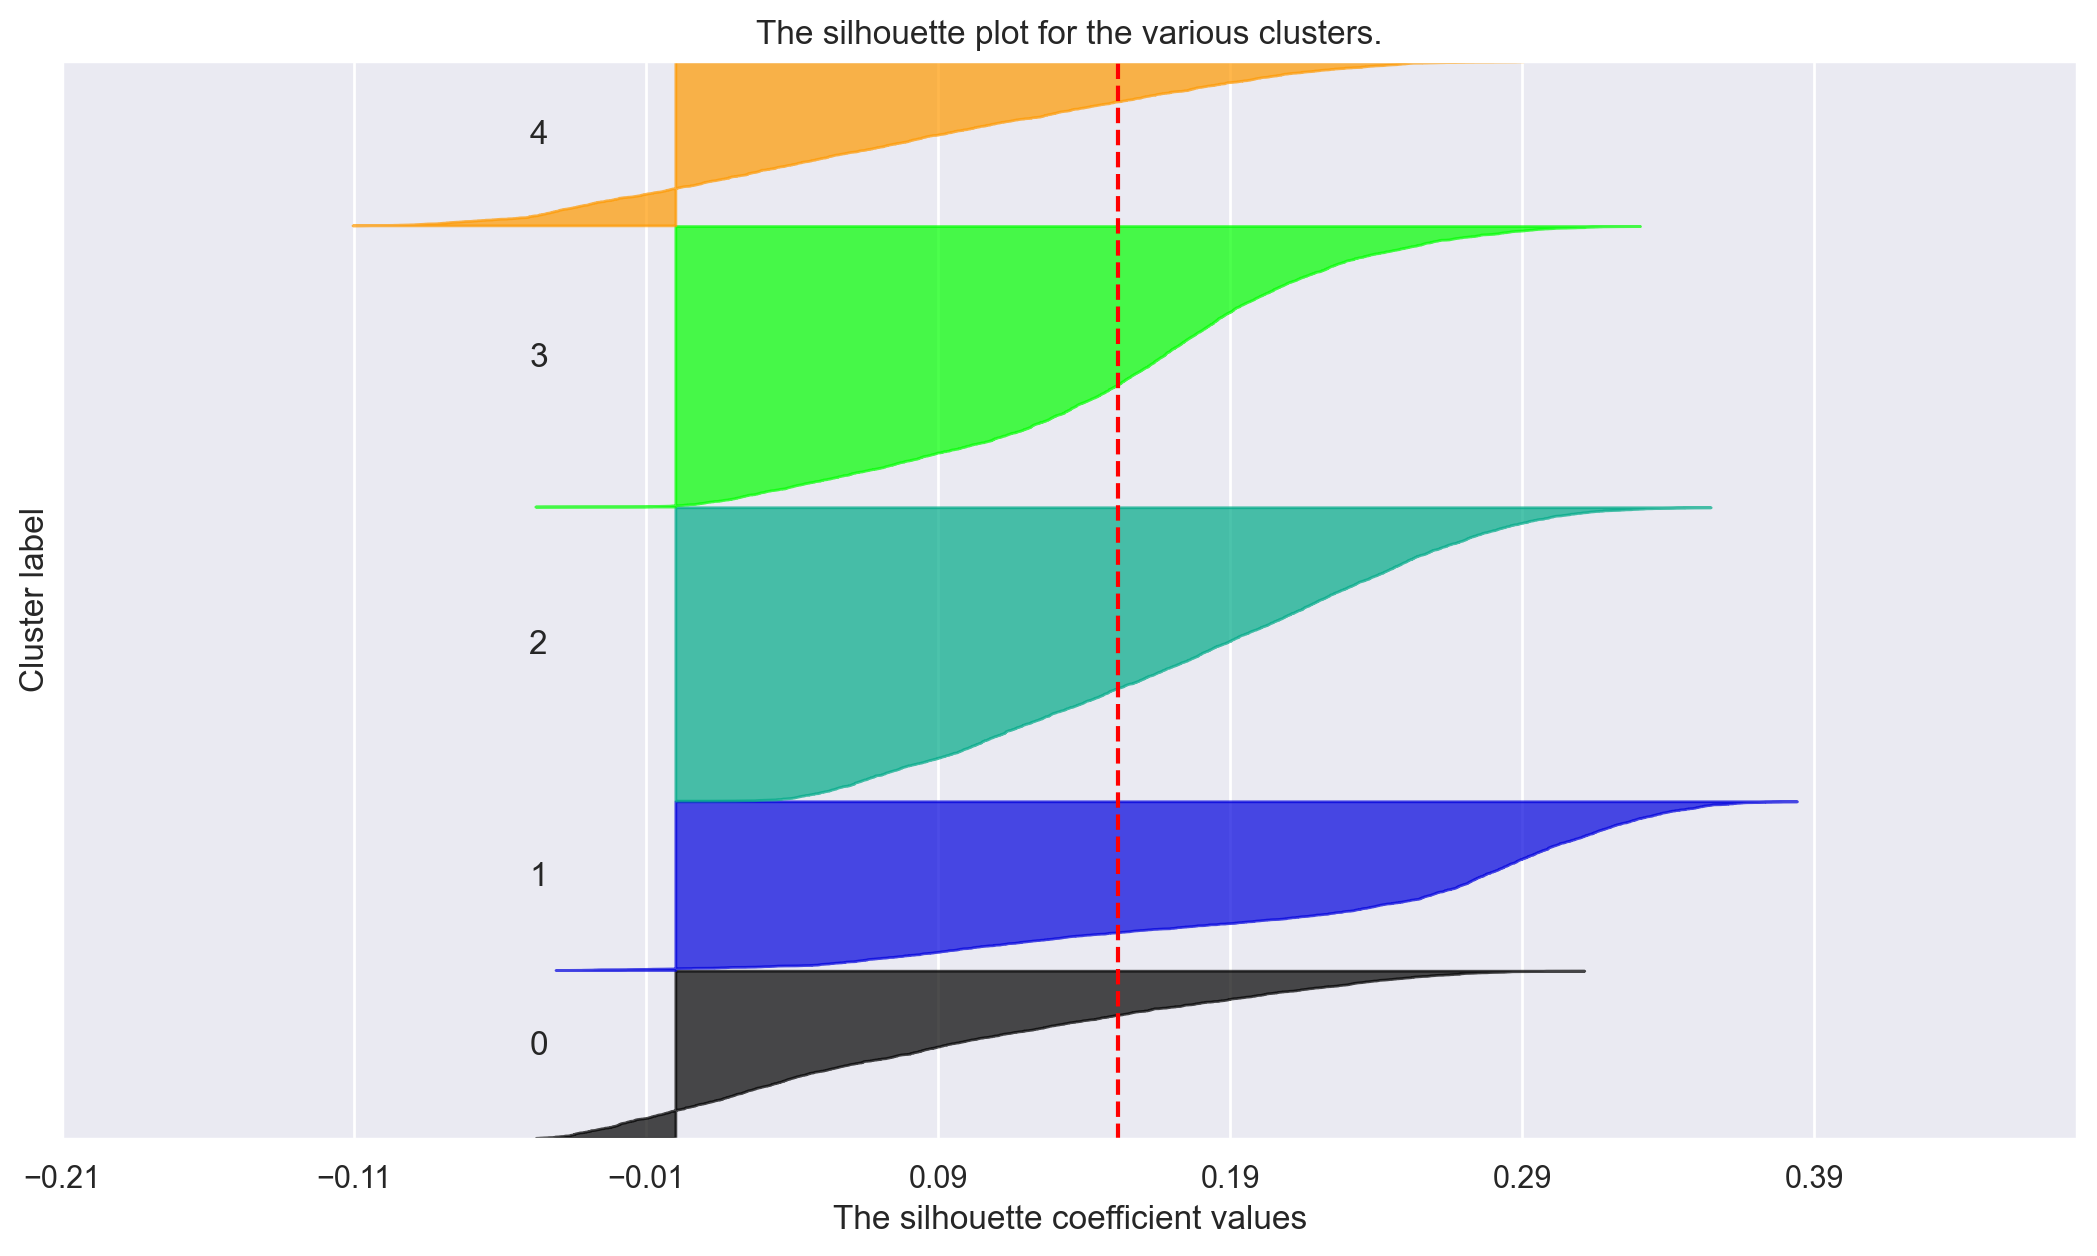

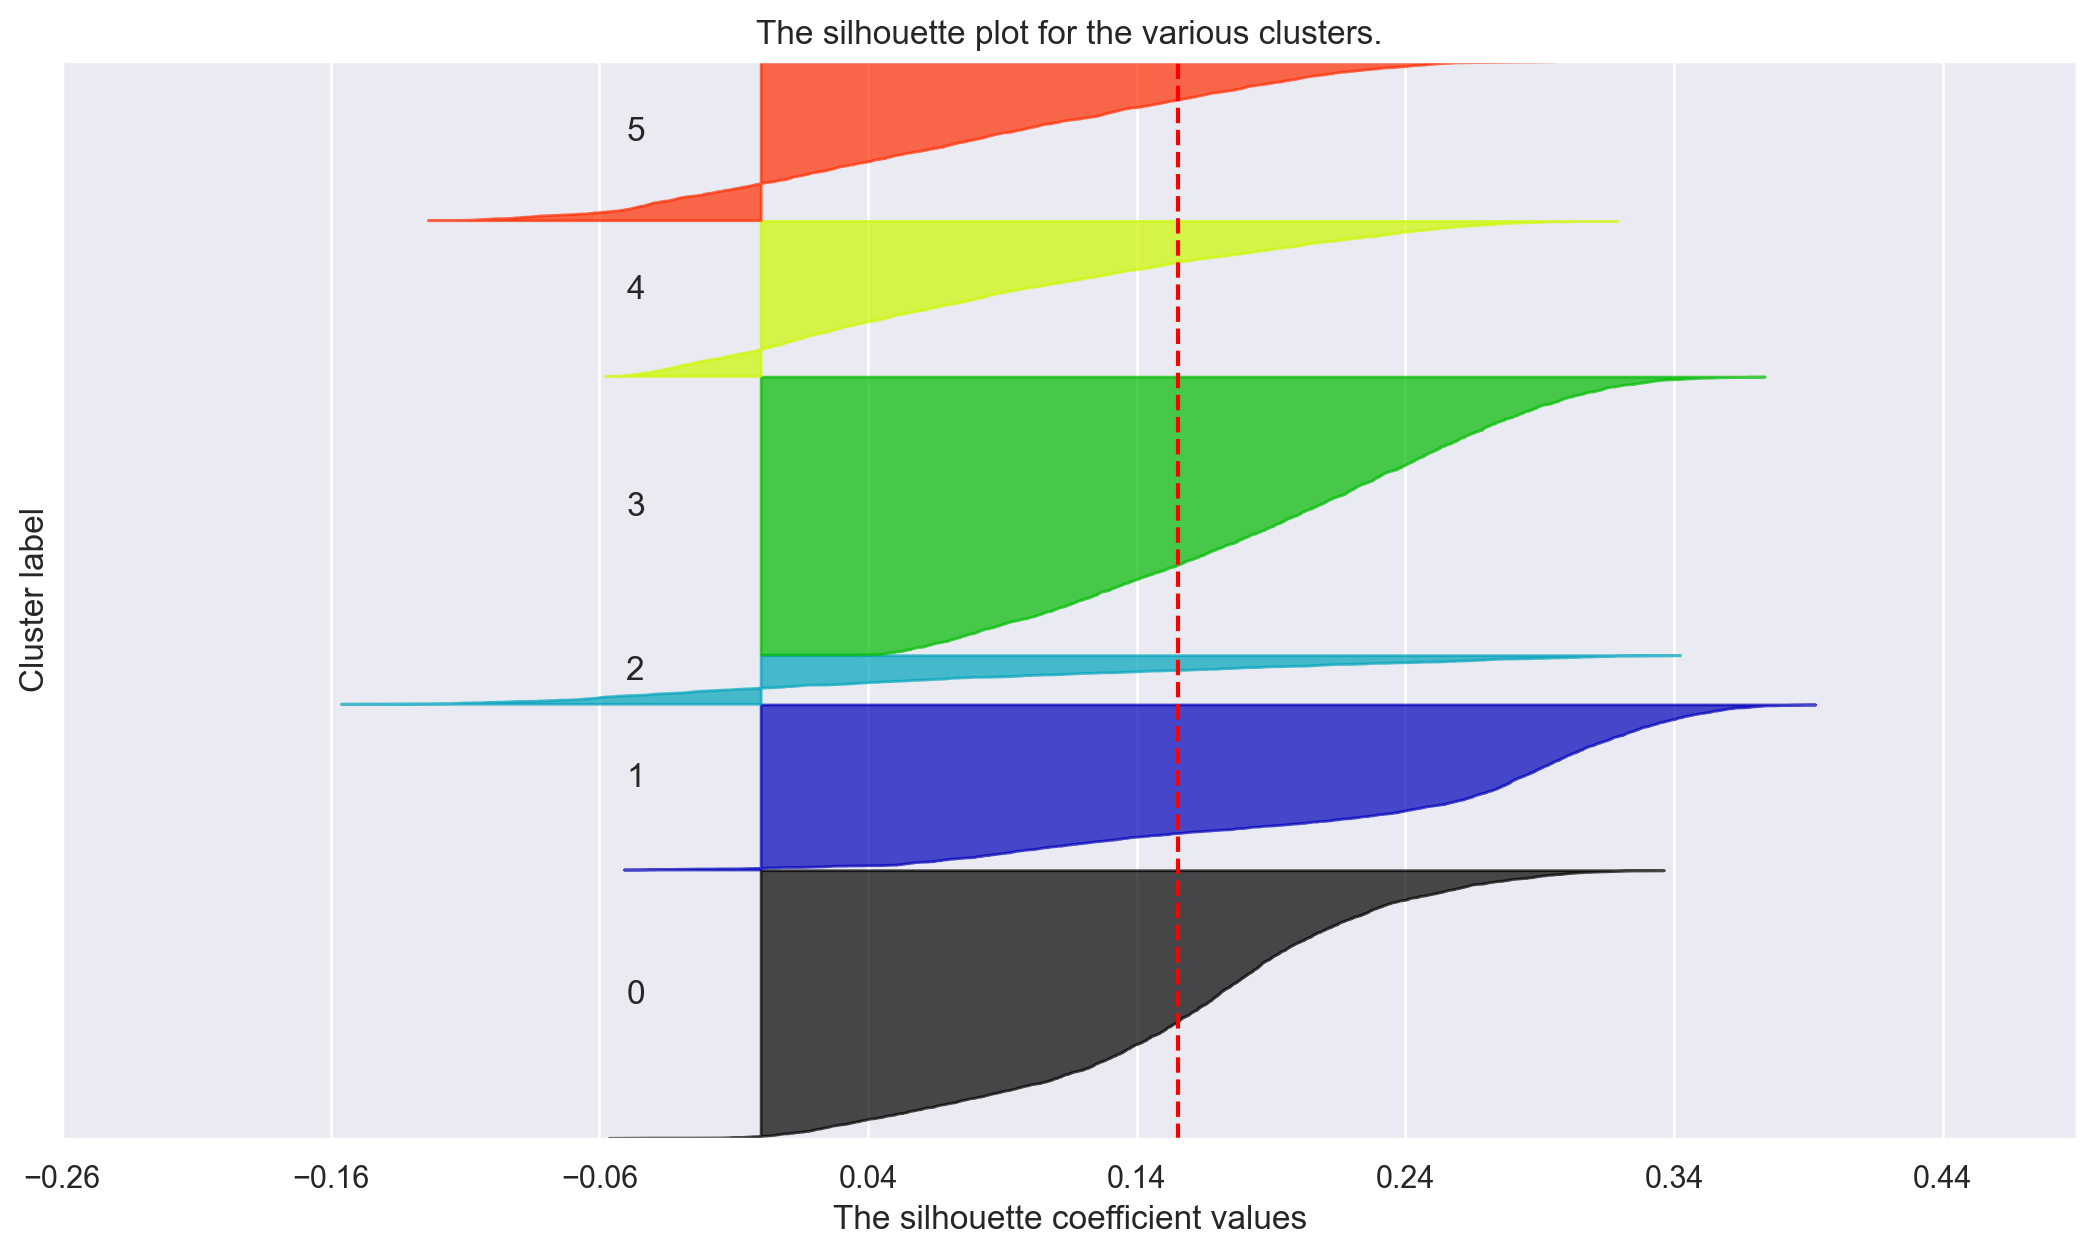

In [45]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(X2)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X2, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X2, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X2) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)


Selection of the Optimal Number of Clusters:

To determine the optimal number of clusters, the **elbow method**  and **average silhouette coefficient** were applied. The first method involves plotting the within-cluster sum of squares (inertia) against the number of clusters \(k\) and identifying the point where the decrease in inertia begins to slow down significantly. The second method is the mean of the silhouette coefficients computed for all data points.It provides a single summary measure of the overall quality of a clustering solution.  
Higher values indicate well-separated and compact clusters.  
It is commonly used to compare clustering results with different numbers of clusters.  
Like the individual silhouette coefficient, it ranges from **-1 to 1**.
ethod  

From the analysis of the inertia curve, there is a substantial reduction in inertia when increasing the number of clusters from \(k = 2\) to \(k = 4\). After \(k = 4\), the curve flattens, indicating that adding more clusters results in only marginal improvements.

From a strictly statistical perspective, the **average silhouette coefficient** indicates that a solution with **2 clusters** is optimal, as it achieves the highest silhouette score among the tested configurations. This suggests better global separation and cohesion when compared to solutions with a higher number of clusters.

However, the **2-cluster solution is highly aggregated**, potentially masking meaningful substructures in the data. When increasing the number of clusters to **4**, the average silhouette score decreases, indicating greater overlap between clusters and weaker internal cohesion. This implies that the data do not naturally support a finer partitioning from a geometric standpoint.

Despite this, a **4-cluster solution may still be appropriate** in an exploratory or interpretative context. If the goal is to obtain more granular insights or align the clustering with domain-specific knowledge, accepting a lower silhouette score can be justified.

Therefore, while **2 clusters are statistically preferable**, the choice of **4 clusters can be defended based on interpretability and analytical objectives**, rather than purely on clustering performance metrics.




### Density Clustering

Mean shift

In [ ]:
X3 = X_num.copy()

In [ ]:
# CORRECT approach - data-driven bandwidth
bandwidth = estimate_bandwidth(X3, quantile=0.06, random_state=1)
bandwidth


In [ ]:
# Apply Mean Shift with estimated bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
    # bin_seeding=True for faster convergence (bins defined by bandwidth); default False, uses all points as seeds
    # n_jobs=4 to use 4 CPU cores for parallel processing; default is 1 (no parallelism)

ms_labels = ms.fit_predict(X3)

In [ ]:
n_clusters = len(np.unique(ms_labels))

print(pd.Series(ms_labels).value_counts().sort_index())

In [ ]:
r2 = get_rsq(merged_df, X_num, ms_labels)
print(f"R² score: {r2:.4f}")

### Fuzzy Clustering (extra value)

In [36]:
#X_cat = X_cat.copy()
X_num = X_num.copy()

XX = np.hstack([X_num])

In [37]:
X_fuzzy = XX.T

n_clusters = 4

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_fuzzy,
    c=n_clusters,
    m=2.0,    
    error=0.005,
    maxiter=1000,
    init=None,
    seed=42
)


In [38]:
fpc_values = []

for c in range(2, 8):
    _, _, _, _, _, _, fpc = fuzz.cluster.cmeans(
        X_fuzzy, c=c, m=2, error=0.005, maxiter=500
    )
    fpc_values.append(fpc)


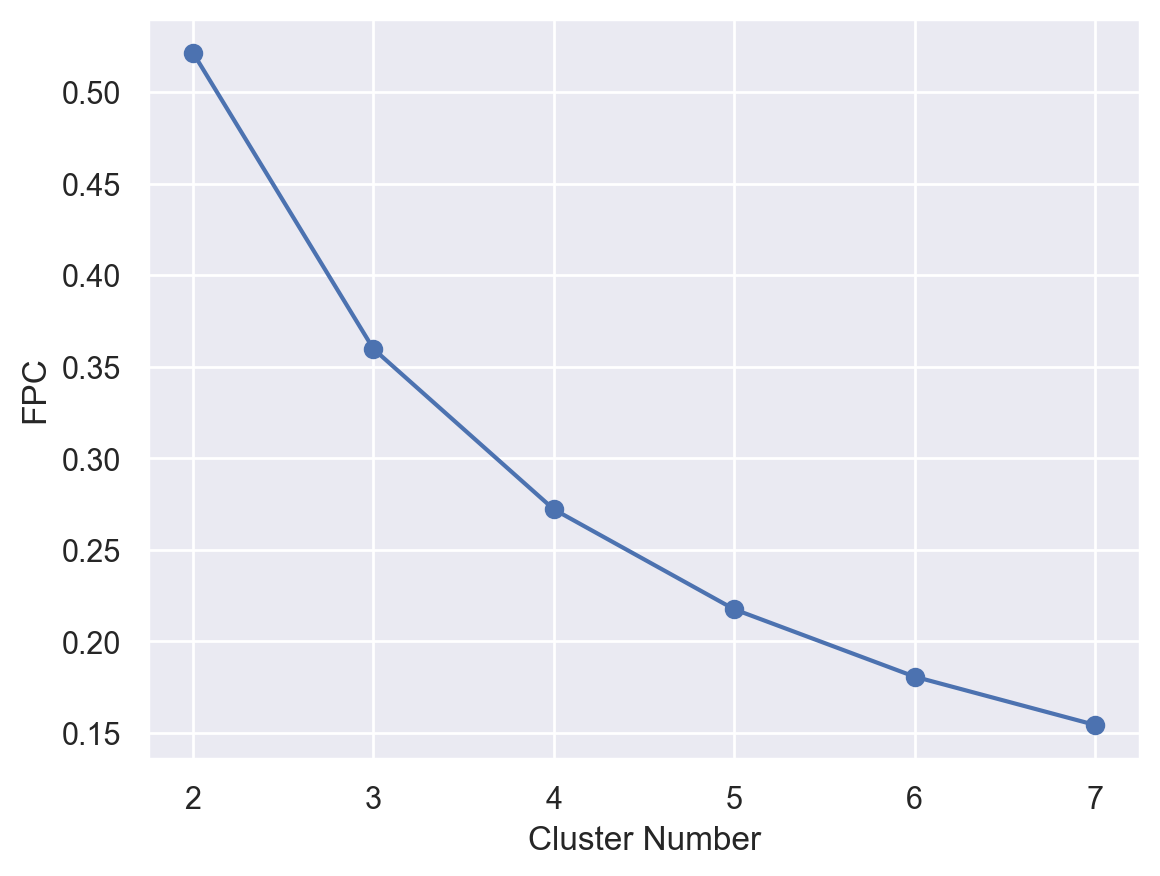

In [39]:
plt.plot(range(2, 8), fpc_values, marker="o")
plt.xlabel("Cluster Number")
plt.ylabel("FPC")
plt.show()


### Comparing different types of clusters

In [40]:
merged_df['cluster'] = labels_hc3
merged_df["Kmeans"] = kmeans.fit_predict(X)
merged_df["FuzzyCluster"] = np.argmax(u, axis=0)
merged_df["Membership_Strength"] = np.max(u, axis=0)

In [41]:
cluster_comparison = pd.DataFrame({
    'Hierarchical': merged_df['cluster'], 'KMeans': merged_df['Kmeans'], 'Fuzzy': merged_df['FuzzyCluster']
})

In [42]:
cluster_comparison

,Hierarchical,KMeans,Fuzzy
Loyalty#,,,
100018,2,1,1
100102,1,0,1
100140,2,1,0
100214,2,1,0
100272,1,0,1
...,...,...,...
999902,1,0,1
999911,0,3,3
999940,0,2,3
